In [1]:
import os
import math
import joblib
import datetime
import pandas as pd
import matplotlib.pyplot as plt

import ee
import geemap
from geemap import ml
from geemap import colormaps
from geemap import cartoee
import cartopy.crs as ccrs

In [2]:
# Initialize Earth Engine
try:
    # ee.Authenticate()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
    print('Google Earth Engine initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine failed to initialize!', e)
    raise

Google Earth Engine initialized successfully!


In [345]:
INPUT_FOLDER = "./rfr_joblib"
OUTPUT_FOLDER = "./rfr_csv"
AEZ = 15
date = "2025-06-29"
PRED_VARIABLE = "N"
PLOTS_DIR = "./plots"
PLOT_SAVE_PATH = os.path.join(os.path.join(PLOTS_DIR, f"AEZ_{AEZ}"), PRED_VARIABLE)
MODEL_FILE_NAME = f"rfr_model_{date}_AEZ_{AEZ}_{PRED_VARIABLE}.joblib"
rf = joblib.load(os.path.join(INPUT_FOLDER, MODEL_FILE_NAME))
CSV_FILE_NAME = f"rf_trees_t{rf.get_params()['n_estimators']}_d{rf.get_params()['max_depth']}_{date}_AEZ_{AEZ}_{PRED_VARIABLE}.csv"
out_csv = os.path.join(OUTPUT_FOLDER, CSV_FILE_NAME)

classifier = ml.csv_to_classifier(out_csv)

In [346]:
# x = classifier.getInfo()
# print([len(x['treeStrings'][i]) for i in range(len(x['treeStrings']))])

In [347]:
features = rf.feature_names_in_
features

array(['temp', 'RI', 'elevation', 'precipitation', 'clay05', 'sand05',
       'silt05', 'sand515', 'longitude', 'latitude'], dtype=object)

In [348]:
aez_fc = ee.FeatureCollection("projects/ee-aakash312000/assets/Agro_Ecological_Regions")
current_aez = aez_fc.filter(ee.Filter.eq('ae_regcode', AEZ))
AOI = current_aez

In [349]:
def add_indices(image):
    indices = []

    # NDVI - Normalized Difference Vegetation Index
    if 'NDVI' in features:
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        indices.append(ndvi)

    # EVI - Enhanced Vegetation Index
    if 'EVI' in features:
        evi = image.expression(
            '2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)', {
                'NIR': image.select('B8'),
                'RED': image.select('B4'),
                'BLUE': image.select('B2')
            }).rename('EVI')
        indices.append(evi)

    # NDWI - Normalized Difference Water Index
    if 'NDWI' in features:
        ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
        indices.append(ndwi)

    # SAVI - Soil Adjusted Vegetation Index
    if 'SAVI' in features:
        savi = image.expression(
            '(NIR - RED) / (NIR + RED + 0.5) * 1.5', {
                'NIR': image.select('B8'),
                'RED': image.select('B4')
            }).rename('SAVI')
        indices.append(savi)

    # BI - Brightness Index
    if 'BI' in features:
        bi = image.expression(
            'sqrt((RED**2 + GREEN**2 + BLUE**2) / 3)', {
                'RED': image.select('B4'),
                'GREEN': image.select('B3'),
                'BLUE': image.select('B2')
            }).rename('BI')
        indices.append(bi)

    # SI - Simple Index
    if 'SI' in features:
        si = image.normalizedDifference(['B4', 'B2']).rename('SI')
        indices.append(si)

    # HI - Hue Index
    if 'HI' in features:
        hi = image.expression(
            '(2 * RED - GREEN - BLUE) / (GREEN - BLUE)', {
                'RED': image.select('B4'),
                'GREEN': image.select('B3'),
                'BLUE': image.select('B2')
            }).rename('HI')
        indices.append(hi)

    # CI - Color Index
    if 'CI' in features:
        ci = image.normalizedDifference(['B4', 'B3']).rename('CI')
        indices.append(ci)

    # RI - Redness Index
    if 'RI' in features:
        ri = image.expression(
            'RED**2 / (BLUE * GREEN**3)', {
                'RED': image.select('B4'),
                'GREEN': image.select('B3'),
                'BLUE': image.select('B2')
            }).rename('RI')
        indices.append(ri)

    # TGSI - Transformed Green Soil Index
    if 'TGSI' in features:
        tgsi = image.normalizedDifference(['B11', 'B8']).rename('TGSI')
        indices.append(tgsi)

    # NCI - Normalized Chlorophyll Index
    if 'NCI' in features:
        nci = image.normalizedDifference(['B11', 'B12']).rename('NCI')
        indices.append(nci)

    # GNDVI - Green NDVI
    if 'GNDVI' in features:
        gndvi = image.normalizedDifference(['B8', 'B3']).rename('GNDVI')
        indices.append(gndvi)

    # Return image with all computed indices added as bands
    return image.addBands(indices) if indices else image

In [350]:
# Define the update function for Sentinel-2
def normalize(image):
    return image.divide(10000)

# Define the update function for LST
def update(image):
    return image.multiply(0.002)

def load_soil_image(property_name, features, roi):
    band_maps = {
        'sand': {'sand05': 'sand_0-5cm_mean', 'sand515': 'sand_5-15cm_mean'},
        'silt': {'silt05': 'silt_0-5cm_mean', 'silt515': 'silt_5-15cm_mean'},
        'clay': {'clay05': 'clay_0-5cm_mean', 'clay515': 'clay_5-15cm_mean'}
    }

    band_map = band_maps.get(property_name, {})
    selected = [(v, k) for k, v in band_map.items() if k in features]
    if selected:
        bands, names = zip(*selected)
        return ee.Image(f"projects/soilgrids-isric/{property_name}_mean").select(list(bands)).rename(list(names)).clip(roi)
    return None

roi = AOI.geometry()

s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
          .filterBounds(roi)
          .filterDate('2023-01-01', '2023-12-31')
          .select(['B2','B3','B4','B8','B11','B12'])
          .map(normalize)
          .map(add_indices)
          .mean())

images = [s2]

if 'temp' in features:
    # Load MODIS LST data
    temp = (ee.ImageCollection("MODIS/061/MOD11A2")
            .select('LST_Day_1km')
            .filterDate('2023-01-01', '2023-12-31')
            .filterBounds(roi)
            .map(update)
            .mean()
            .rename('temp'))
    
    images.append(temp)

if 'precipitation' in features:
    # Load CHIRPS Precipitation data
    preci = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
             .filterDate('2023-01-01', '2023-12-31')
             .filterBounds(roi)
             .mean()
             .rename('precipitation'))

    images.append(preci)

# Load SRTM Elevation data
elevation = (ee.Image("USGS/SRTMGL1_003")
             .clip(roi)
             .rename('elevation'))

if 'elevation' in features:
    images.append(elevation)


# Load slope image
slope = ee.Terrain.slope(elevation).rename('slope')
# Load aspect image
aspect = ee.Terrain.aspect(elevation).rename('aspect')

if 'slope' in features:
    images.append(slope)

if 'aspect' in features:
    images.append(aspect)

if 'TWI' in features:
    # Convert slope from degrees to radians
    slope_radians = slope.multiply(math.pi).divide(180)
    # Compute tan(slope)
    tan_slope = slope_radians.tan()
    # Replace 0 values in tan_slope to avoid division by zero
    safe_slope = tan_slope.where(tan_slope.eq(0), 0.001)
    # Load flow accumulation (MERIT Hydro upstream area)
    flow_accumulation = ee.Image("MERIT/Hydro/v1_0_1").select("upa").clip(roi)
    # Compute TWI = ln(flow accumulation / tan(slope))
    twi = flow_accumulation.divide(safe_slope).log().rename('TWI')
    images.append(twi)

sand = load_soil_image('sand', features, roi)
if sand is not None:
    images.append(sand)

silt = load_soil_image('silt', features, roi)
if silt is not None:
    images.append(silt)

clay = load_soil_image('clay', features, roi)
if clay is not None:
    images.append(clay)

latlon = ee.Image.pixelLonLat().select(["latitude", "longitude"])

# Combine all bands into a single image
s2_with_indices = (ee.Image(images).toFloat())

# Add latitude and longitude bands
s2_with_indices = s2_with_indices.addBands(latlon)

# Clip final image to the 'state' region
s2_with_indices = s2_with_indices.clip(AOI)

In [351]:
classified = s2_with_indices.classify(classifier)

# min_max_values = classified.reduceRegion(
#     reducer=ee.Reducer.minMax(),
#     geometry=roi,
#     bestEffort=True
# )
# print('minMaxValues', min_max_values.getInfo())

In [352]:
color_palette = colormaps.get_palette('RdYlGn', n_class=5)

# Now you can use it for visualization parameters
viz_params = {
    'min': 0,
    'max': 750,
    'palette': color_palette
}

In [353]:
# display results
Map = geemap.Map()

In [354]:
Map.centerObject(AOI, zoom=5)
Map.addLayer(AOI, {'color': 'blue'}, "ROI")

Map.addLayer(
    classified,
    viz_params,
    f"predicted_{PRED_VARIABLE}",
)

Map.add_legend(
    title="Predicted Nitrogen (kg/ha)",  # Set the title of the legend
    labels=['0-150', '151-300', '301-450', '451-600', '601-750'],  # Labels for different ranges of values
    colors=color_palette  # Use the defined ColorBrewer Greens palette
)

In [355]:
Map

Map(center=[25.01001951620938, 90.46950248582417], controls=(WidgetControl(options=['position', 'transparent_b…

In [356]:
# export image to google drive
# task = ee.batch.Export.image.toDrive(
#     image=classified,
#     description=f"AEZ_{AEZ}_{PRED_VARIABLE}_AGRI_2023-24",
#     region=roi.bounds(), 
#     scale=30,
#     maxPixels=1e12,
#     folder="EarthEngineExports"
# )

# export asset to google drive
task = ee.batch.Export.image.toAsset(
    image=classified,
    description=f"AEZ_{AEZ}_{PRED_VARIABLE}_AGRI_2023-24",
    assetId=f'projects/ee-aakash312000/assets/AEZ_{AEZ}_{PRED_VARIABLE}_AGRI_2023-24',
    region=roi.bounds(),
    scale=30,
    maxPixels=1e12
)

In [357]:
task.start()

In [358]:
task.status()

{'state': 'READY',
 'description': 'AEZ_15_N_AGRI_2023-24',
 'priority': 100,
 'creation_timestamp_ms': 1751220457491,
 'update_timestamp_ms': 1751220457491,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'EXFX2U3OJDOKSYI575TT25N7',
 'name': 'projects/227570458547/operations/EXFX2U3OJDOKSYI575TT25N7'}

TypeError: Figure.savefig() missing 1 required positional argument: 'fname'

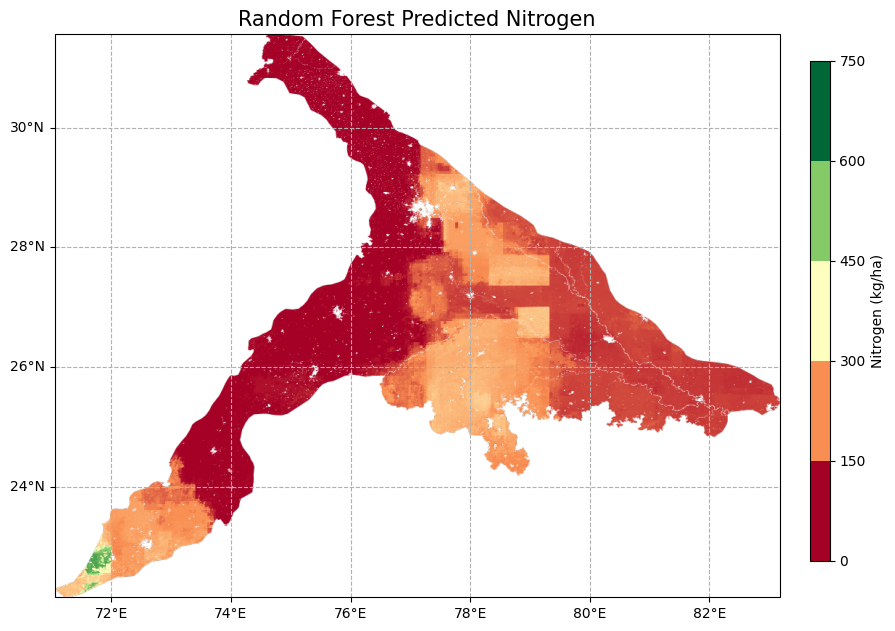

In [52]:
vis = {
    "min": 0, 
    "max": 750,
    'palette' : colormaps.get_palette("RdYlGn", n_class=5),
}

fig = plt.figure(figsize=(10, 10))

bbox = list(geemap.get_bounds(roi.getInfo()))

# E, S, W, N
region = [bbox[2], bbox[1], bbox[0], bbox[3]]

# use cartoee to get a map
ax = cartoee.get_map(classified, region=region, vis_params=vis)

# print(ax, type(ax))

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(
    ax, vis, loc="right", label="Nitrogen (kg/ha)", orientation="vertical", discrete=True
)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[2, 2], linestyle="--")

# # add north arrow
# cartoee.add_north_arrow(
#     ax, text="N", xy=(0.85, 0.25), text_color="black", arrow_color="black", fontsize=20
# )

# # add scale bar
# cartoee.add_scale_bar_lite(
#     ax, length=100, xy=(0.9, 0.05), fontsize=20, color="black", unit="km"
# )

ax.set_title(label="Random Forest Predicted Nitrogen", fontsize=15)
plt.savefig()
plt.show()

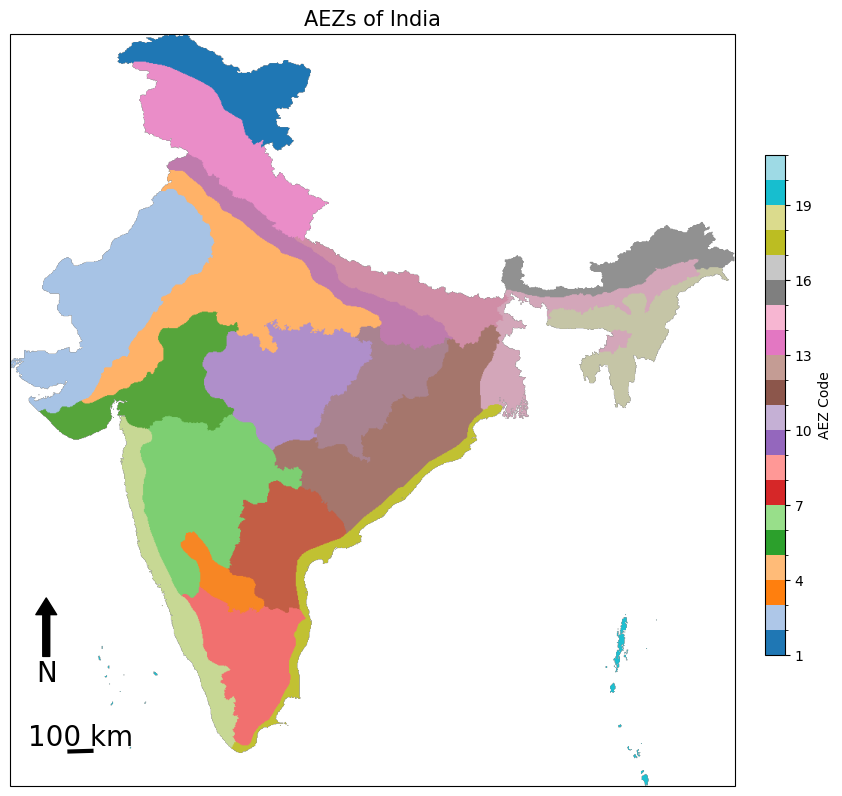

In [13]:
vis = {
    "min": 1, 
    "max": 21, 
    # 'palette' : colormaps.get_palette("viridis", n_class=20),
    'palette' : colormaps.get_palette("tab20")
}

fig = plt.figure(figsize=(10, 10))

bbox = list(geemap.get_bounds(aez_fc.geometry().getInfo()))

# E, S, W, N
region = [bbox[2], bbox[1], bbox[0], bbox[3]]

cmap = "viridis"  # colormap we want to use

# use cartoee to get a map
ax = cartoee.get_map(aez_raster, region=region, vis_params=vis)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(
    ax, vis, loc="right", label="AEZ Code", orientation="vertical", discrete=True
)

# add gridlines to the map at a specified interval
# cartoee.add_gridlines(ax, interval=[5, 5], linestyle="--")

# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.05, 0.25), text_color="black", arrow_color="black", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=100, xy=(0.1, 0.05), fontsize=20, color="black", unit="km"
)

# add coastlines using the cartopy api
# ax.coastlines(color="red")

ax.set_title(label="AEZs of India", fontsize=15)
plt.savefig("aez_india.png", dpi=300)
plt.show()